
따라서 학습데이터를 naver api를 이용해 감성 파악하고 알맞게 분리됨을 확인한 coupang 데이터와 2019 데이터 이용

# 머신러닝 LSTM모델을 이용한 감성분석 진행 02

train : only coupang만!

test: 직접 감성파악한 문장 300 문장 (다수결로 확정) 

pred: 2015, 2020 blog cafe데이터

# colab 환경에서 작성
- konlpy intsall

In [2]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk-13.0.2"

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

# 0906 머신러닝 LSTM 모델

## 01. 데이터 불러오기 확인

## - 데이터 불러오기

### - train data 1: 2019

In [3]:
import pandas as pd
train_df = pd.read_excel('naver_senti_sentence_2019.xlsx') # 데이터 불러오기
print( len(train_df) )
train_df[0:3] # 확인

16594


,idx,train,api
0,0,우리 아이를 위한 첫 요리 쌀미음 만들기 하루 하루가 기적같고 신기하기만 한 우리...,positive
1,1,가능하면 천천히 시작해서 덜 복잡한 육아를 좀 더 즐기고 싶었건만 왜 이리 아이가...,neutral
2,2,초기이유식 쌀미음 만들기 준비물 불린쌀 15 물 200 정 말 간단하고 쉬운 쌀미...,neutral


In [4]:
score = []
for i in range(len(train_df)):
  if train_df['api'][i] == 'positive':
    result = 1
  elif train_df['api'][i] == 'neutral':
    result = 0
  else:
    result = -1
  score.append(result)

# 데이터 프레임에 리스트 삽입
train_df.insert(3,'score',score, True) #insert(삽입위치,칼럼명, 칼럼데이터, true)
train_df

,idx,train,api,score
0,0,우리 아이를 위한 첫 요리 쌀미음 만들기 하루 하루가 기적같고 신기하기만 한 우리...,positive,1
1,1,가능하면 천천히 시작해서 덜 복잡한 육아를 좀 더 즐기고 싶었건만 왜 이리 아이가...,neutral,0
2,2,초기이유식 쌀미음 만들기 준비물 불린쌀 15 물 200 정 말 간단하고 쉬운 쌀미...,neutral,0
3,3,레시피들마다 다 그람수나 쌀과 물의 비율이 다르기 때문에 충분히 비교 해 보고 원...,neutral,0
4,4,쌀 은 수북하게 한숟가락 정도 떠서 미리 물에 불려둔다,neutral,0
...,...,...,...,...
16589,16589,저희 아가는 150일에 시작 우리나라에서 아기의 첫 이유식 시작은 알레르기 반응이...,neutral,0
16590,16590,첫 이유식이라 해주고 싶으셨다고 고마워 맘 친정엄마 덕분에 너무나 순조롭게 시작중...,neutral,0
16591,16591,이유식을 준비하는 엄마들이라면 한번쯤 들어봤을 이유식전용 냄비 릴리팟 냄비 열전도율...,positive,1
16592,16592,앞 옆 위쪽 심지어 손잡이의 용접된 부분까지 매끄럽게 잘 만들어졌더라구요들어보니 ...,negative,-1


 0    9318
 1    5550
-1    1726
Name: score, dtype: int64

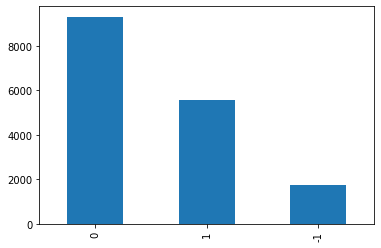

In [5]:
# train data의 긍부정 비율 확인 : 긍정1 / 중립0 / 부정 -1
%matplotlib inline 
import matplotlib.pyplot as plt

train_df['score'].value_counts().plot(kind='bar')
train_df['score'].value_counts()

### - train data 2 : 쿠팡

In [6]:
import pandas as pd
train_df_2 = pd.read_excel('total_senti_coupang.xlsx') # 데이터 불러오기
print( len(train_df_2) )
train_df_2[0:3] # 확인

15730


,idx,train,api,score
0,0,밥맛하면\n곰곰쌀이죠,neutral,0
1,1,비록 다이어트에 실패를 가져다 준\n곰곰쌀이지만\n맛있는 걸 오또케요\n진짜 최고입니다,positive,1
2,2,♡지난번 구입해서 먹고 다 먹어서\n또 구입했습니다,neutral,0


 1    7771
 0    5035
-1    2924
Name: score, dtype: int64

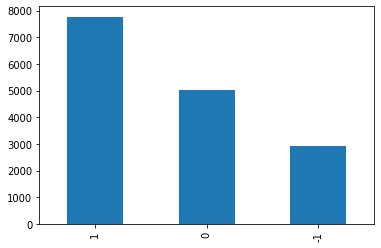

In [7]:
# train data의 긍부정 비율 확인 : 긍정1 / 중립0 / 부정 -1
%matplotlib inline 
import matplotlib.pyplot as plt

train_df_2['score'].value_counts().plot(kind='bar')
train_df_2['score'].value_counts()

### - train 합치기

In [8]:
# train_df_2에 train_df 합침
train_df_2 = pd.concat([train_df, train_df_2], ignore_index= True)
train_df_2.reset_index(drop=False,inplace=True)
train_df_2

,index,idx,train,api,score
0,0,0,우리 아이를 위한 첫 요리 쌀미음 만들기 하루 하루가 기적같고 신기하기만 한 우리...,positive,1
1,1,1,가능하면 천천히 시작해서 덜 복잡한 육아를 좀 더 즐기고 싶었건만 왜 이리 아이가...,neutral,0
2,2,2,초기이유식 쌀미음 만들기 준비물 불린쌀 15 물 200 정 말 간단하고 쉬운 쌀미...,neutral,0
3,3,3,레시피들마다 다 그람수나 쌀과 물의 비율이 다르기 때문에 충분히 비교 해 보고 원...,neutral,0
4,4,4,쌀 은 수북하게 한숟가락 정도 떠서 미리 물에 불려둔다,neutral,0
...,...,...,...,...,...
32319,32319,15725,2인이 살고 있는 집이구 저는 주말에만 빕에서 밥을 먹어서\n양이 좀 많은 편입니다,positive,1
32320,32320,15726,여름이라 더 작은거 사려다가 그냥 재구매했구요,neutral,0
32321,32321,15727,밥맛은 좋아요,positive,1
32322,32322,15728,품질 관리 잘 하시는거 같아요,positive,1


 0    14353
 1    13321
-1     4650
Name: score, dtype: int64

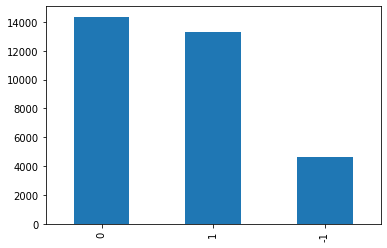

In [12]:
# 비율 확인

train_df_2['score'].value_counts().plot(kind='bar')
train_df_2['score'].value_counts()

## 학습데이터 비율정해 뽑기 

### - case0: 비율조정 x : selected_0

In [23]:
selected_train = train_df_2
selected_train

,index,idx,train,api,score
0,0,0,우리 아이를 위한 첫 요리 쌀미음 만들기 하루 하루가 기적같고 신기하기만 한 우리...,positive,1
1,1,1,가능하면 천천히 시작해서 덜 복잡한 육아를 좀 더 즐기고 싶었건만 왜 이리 아이가...,neutral,0
2,2,2,초기이유식 쌀미음 만들기 준비물 불린쌀 15 물 200 정 말 간단하고 쉬운 쌀미...,neutral,0
3,3,3,레시피들마다 다 그람수나 쌀과 물의 비율이 다르기 때문에 충분히 비교 해 보고 원...,neutral,0
4,4,4,쌀 은 수북하게 한숟가락 정도 떠서 미리 물에 불려둔다,neutral,0
...,...,...,...,...,...
32319,32319,15725,2인이 살고 있는 집이구 저는 주말에만 빕에서 밥을 먹어서\n양이 좀 많은 편입니다,positive,1
32320,32320,15726,여름이라 더 작은거 사려다가 그냥 재구매했구요,neutral,0
32321,32321,15727,밥맛은 좋아요,positive,1
32322,32322,15728,품질 관리 잘 하시는거 같아요,positive,1


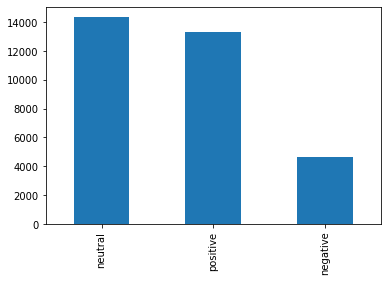

In [26]:
selected_train['api'].value_counts().plot(kind='bar')

#train_selected_1저장
selected_train.to_excel('train_ratio/train_selected0.xlsx')

### - case1 : -1 : 4650 // 1:4650 // 0 : 4650

In [10]:
# 긍부정 비율 동일하게 학습
# -1 : 4650 // 1:4650 // 0 : 4650
all_positive_su, all_negative_su,all_netural_su =[],[],[]
for i in range(32324):
  if train_df_2['score'][i]== 1:
    all_positive_su.append(train_df_2['index'][i])
  if train_df_2['score'][i]== -1:
    all_negative_su.append(train_df_2['index'][i])
  if train_df_2['score'][i]== 0:
    all_netural_su.append(train_df_2['index'][i])
    

import random
random.seed(2021)

rand_negative_su = random.sample(all_negative_su, 4650) 
rand_netural_su = random.sample(all_netural_su, 4650) 
rand_positive_su = random.sample(all_positive_su, 4650) 
print ( len( rand_negative_su), len(rand_netural_su),len( rand_positive_su ) )

selected_train = pd.concat ( [ train_df_2.loc[rand_positive_su,:], train_df_2.loc[rand_netural_su,:],train_df_2.loc[rand_negative_su,:] ], ignore_index=True )
selected_train

4650 4650 4650


,index,idx,train,api,score
0,22291,5697,\n평이좋아 구매했고 두번째도 의심없이 주문했어요,positive,1
1,13235,13235,구수한 것 같기도 신맛이 느껴지기도 오묘한 맛 추운 날 가볍게 먹기에 좋을 것 같다,positive,1
2,21222,4628,\n밥맛도 달게 느껴지고 진짜 맛있다 맛있다 소리가\n절로나오네요,positive,1
3,1345,1345,쌀빵체험팩 구성 플레인쌀빵1 호두베리쌀빵1 한끼설기1 쌀카스테라1 바나나쌀파운드1...,positive,1
4,3809,3809,김치 올려서 떡국 훌훌 먹기에 좋고 성인 1인분으로 양도 충분하고 간단하게 조리해...,positive,1
...,...,...,...,...,...
13945,22463,5869,공짜로받아도 안먹을 쌀상태에요,negative,-1
13946,26623,10029,(잠금 뚜껑 있는것)\n근데 이번 여름은 너무 습했는지\n곰팡이가 나버렸네요,negative,-1
13947,22987,6393,맛없음 맛없음 맛없음밥을 하니 밥이 누래요,negative,-1
13948,23184,6590,\n822일 도정쌀 827일주문\n대체 어떻게하면 이딴게\n상품평보니 벌레 부터 ...,negative,-1


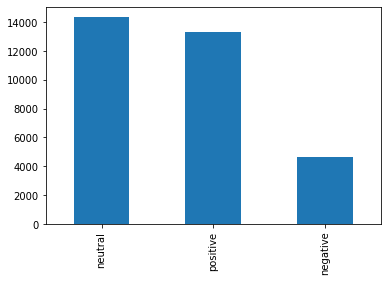

In [24]:
selected_train['api'].value_counts().plot(kind='bar')

#train_selected_1저장
selected_train.to_excel('train_ratio/train_selected1.xlsx')

In [ ]:
#학습데이터 수 조정
# result2 = pd.concat([df1,df2], ignore_index=True)
selected_train = pd.concat ( [ train_df_2.loc[rand_positive_su,:], train_df_2.loc[all_netural_su,:],train_df_2.loc[all_negative_su,:] ], ignore_index=True )
selected_train

,idx,train,api,score
0,5697,시중에 판매하는 대부분의 과자들이 30 인 것에 반해 처으미야 떡뻥과 스틱은 40...,positive,1
1,13235,구수한 것 같기도 신맛이 느껴지기도 오묘한 맛 추운 날 가볍게 먹기에 좋을 것 같다,positive,1
2,4628,해피키친 찐연맘왔어요,neutral,0
3,1345,쌀빵체험팩 구성 플레인쌀빵1 호두베리쌀빵1 한끼설기1 쌀카스테라1 바나나쌀파운드1...,positive,1
4,3809,김치 올려서 떡국 훌훌 먹기에 좋고 성인 1인분으로 양도 충분하고 간단하게 조리해...,positive,1
...,...,...,...,...
23648,15686,요식혀주고 이제 부터 아주 긴장되는 시간이 두구 두구 온도를 맞출라면 하루종일 온도...,neutral,0
23649,15705,네이버 고고맘 채널에 초기이유식 쌀미음 만드는 영상부터 소개됩니다,neutral,0
23650,15711,이유식강의 및 코칭을 하면서 수많은 정보가 오히려 독이 될 수의정부 디저트 맛집 봄...,positive,1
23651,15719,문의 010 2939 2424요즘 너무 인기 좋은 숫자 케이크입니다,positive,1


In [ ]:
selected_train['score'].value_counts()


 0    5035
-1    2924
 1    2924
Name: score, dtype: int64

In [ ]:
#train_selected_1저장
selected_train.to_excel('train_selected.xlsx')

## - pred: 2015 blog / 2015 cafe

In [15]:
import pandas as pd
pred_df= pd.read_excel('kss_st_2015_blog.xlsx') # 데이터 불러오기
print( len(pred_df) )
pred_df[0:3] # 확인

83227


,idx,sentence_Data,channel,year
0,0,한인마트는 귀찮아서 안가므로 떡볶이를 먹고싶을 때를 대비하여 이전에 마트에서 쌀가루...,blog,2015
1,1,그리고 오늘은 1월 1일 아무래도 설날이나 새해때 떡국을 안먹으면 억울하다 작년에도...,blog,2015
2,2,국물내는 재료따위 없는 나는 떡국까진 사치고 너무 먹고싶었던 고추가루엄청 많이 넣은...,blog,2015


In [16]:
pred_df_2= pd.read_excel('kss_st_2015_cafe.xlsx') # 데이터 불러오기
print( len(pred_df_2) )
pred_df_2[0:3] # 확인

33294


,idx,sentence_Data,channel,year
0,0,세종시로 올해 1월 10일 이사했습니다,cafe,2015
1,1,어제 쌀이 똑 떨어졌는데 마침 까페에 쌀공구가 떴네요,cafe,2015
2,2,내일아침 밥을 하기위해 저녁에 직접 방문드리기로 했습니다,cafe,2015


In [17]:
#pred_df 합쳐서 한번에 진행
pred_df = pd.concat([pred_df, pred_df_2],ignore_index=True)



In [18]:
pred_df

,idx,sentence_Data,channel,year
0,0,한인마트는 귀찮아서 안가므로 떡볶이를 먹고싶을 때를 대비하여 이전에 마트에서 쌀가루...,blog,2015
1,1,그리고 오늘은 1월 1일 아무래도 설날이나 새해때 떡국을 안먹으면 억울하다 작년에도...,blog,2015
2,2,국물내는 재료따위 없는 나는 떡국까진 사치고 너무 먹고싶었던 고추가루엄청 많이 넣은...,blog,2015
3,3,블로그보면 쌀가루로 찹쌀떡진짜 잘 만들던데 내가만든건 만들다가 정말 빡쳤다는 것이 ...,blog,2015
4,4,라는 생각으로 만듬 찹쌀떡이없는 나라에서 산다해도 안먹고 말거야,blog,2015
...,...,...,...,...
116516,33289,식용유 미림맛술 꿀 이렇게 3가지 양념만 넣고 조리 했는데 맛이 와 비린맛 잘 잡아...,cafe,2015
116517,33290,가능한가요 믹서기 청소가 귀찮아서,cafe,2015
116518,33291,담주부터 초기이유식 시작인데 아직 애가 못앉잖아요 다들 그냥 분유주듯 안아서 먹이시나요,cafe,2015
116519,33292,어뭉들어디서 사드시나요 아이간식사먹이는 사이트추천좀해주셔요,cafe,2015


## - pred:2020 blog/ cafe

In [50]:
import pandas as pd
pred_df= pd.read_excel('kss_st_2020_blog.xlsx') # 데이터 불러오기
print( len(pred_df) )
pred_df[0:3] # 확인

115215


,idx,sentence_Data,channel,year
0,0,초기이유식 2단계 소고기미음 차례 나는 튼이이유식 책을보고 만들고 있는데 초기는 책...,blog,2020
1,1,중기이유식 들어가면서 큐브만들고 책 보는중 무튼 엄마들이라면 이유식만들때 참고하는 ...,blog,2020
2,2,나도 도서관에서 2개의 이유식책을 빌렸는데 쌀미음 다음에 순서가 달랐다,blog,2020


In [51]:
pred_df_2= pd.read_excel('kss_st_2020_cafe.xlsx') # 데이터 불러오기
print( len(pred_df_2) )
pred_df_2[0:3] # 확인

33685


,idx,sentence_Data,channel,year
0,0,쌀구움과자 장여진 채미희 지음경향미디어메마른 쌀베이킹계의단비같은 도서가 나타났어요,cafe,2020
1,1,쌀베이킹을 하면서밀베이킹과는 조금다른 결과물에당황할 때도 종종 있거든요,cafe,2020
2,2,클래스를 다녀야하나 고민도해봤는데시간이 없는 저로썬 집에서 끙끙 앓고 있었는데너무 ...,cafe,2020


In [52]:
#pred_df 합쳐서 한번에 진행
pred_df = pd.concat([pred_df, pred_df_2],ignore_index=True)
pred_df

,idx,sentence_Data,channel,year
0,0,초기이유식 2단계 소고기미음 차례 나는 튼이이유식 책을보고 만들고 있는데 초기는 책...,blog,2020
1,1,중기이유식 들어가면서 큐브만들고 책 보는중 무튼 엄마들이라면 이유식만들때 참고하는 ...,blog,2020
2,2,나도 도서관에서 2개의 이유식책을 빌렸는데 쌀미음 다음에 순서가 달랐다,blog,2020
3,3,하나는 야채 하나는 철분을 위해 소고기 나는 완분임에도 야채부터 하고 소고기를 들어...,blog,2020
4,4,최대한 지방없는걸로 달라고 했는데 잘 모르겠다,blog,2020
...,...,...,...,...
148895,33680,재난카드 정부재난카드 카드 온누리 평택사랑권 다가능해요,cafe,2020
148896,33681,주문방법 참고하셔서 주문 주세요,cafe,2020
148897,33682,2만원 이상 무료배달해드려요 2만원 미만은 배송료 2천원입니다 주 문 방 법 1 문...,cafe,2020
148898,33683,2 문자로 동 호수 연락처 보내주시면 주문완료 3 계좌입금 해주시는 분들은 꼭 동 ...,cafe,2020


## 02. 데이터 전처리

###  - train data

In [13]:
# selected_train 확인 : 쿠팡 데이터

# text 컬럼이 non-null인 샘플만 selected_train에 다시 저장
selected_train = selected_train[selected_train['train'].notnull()]

# 수정된 selected_train의 정보를 다시 확인
print(selected_train.info())

# 분류 클래스의 구성을 확인
print(selected_train['score'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13950 entries, 0 to 13949
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   13950 non-null  int64 
 1   idx     13950 non-null  int64 
 2   train   13950 non-null  object
 3   api     13950 non-null  object
 4   score   13950 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 653.9+ KB
None
-1    4650
 1    4650
 0    4650
Name: score, dtype: int64


### - pred data (social)

In [53]:
# pred에 str이 아닌게 존재하네! nan임을 확인함 # 제거하고 데이터 다시 가져옴
for i in range(len(pred_df)):
    if type(pred_df['sentence_Data'][i]) != str :
        print(i)

In [54]:
# 댓글이 있는 항목만 담기(빈 댓글 삭제)
# text 컬럼이 non-null인 샘플만 train_df에 다시 저장
pred_df = pred_df[pred_df['sentence_Data'].notnull()]

# 수정된 train_df의 정보를 다시 확인
print(pred_df.info())

# null값 개수 확인
print(pred_df['sentence_Data'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148900 entries, 0 to 148899
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   idx            148900 non-null  int64 
 1   sentence_Data  148900 non-null  object
 2   channel        148900 non-null  object
 3   year           148900 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 5.7+ MB
None
0


In [55]:
pred_df

,idx,sentence_Data,channel,year
0,0,초기이유식 2단계 소고기미음 차례 나는 튼이이유식 책을보고 만들고 있는데 초기는 책...,blog,2020
1,1,중기이유식 들어가면서 큐브만들고 책 보는중 무튼 엄마들이라면 이유식만들때 참고하는 ...,blog,2020
2,2,나도 도서관에서 2개의 이유식책을 빌렸는데 쌀미음 다음에 순서가 달랐다,blog,2020
3,3,하나는 야채 하나는 철분을 위해 소고기 나는 완분임에도 야채부터 하고 소고기를 들어...,blog,2020
4,4,최대한 지방없는걸로 달라고 했는데 잘 모르겠다,blog,2020
...,...,...,...,...
148895,33680,재난카드 정부재난카드 카드 온누리 평택사랑권 다가능해요,cafe,2020
148896,33681,주문방법 참고하셔서 주문 주세요,cafe,2020
148897,33682,2만원 이상 무료배달해드려요 2만원 미만은 배송료 2천원입니다 주 문 방 법 1 문...,cafe,2020
148898,33683,2 문자로 동 호수 연락처 보내주시면 주문완료 3 계좌입금 해주시는 분들은 꼭 동 ...,cafe,2020


## 03. train / test 분리

### -  train: 쿠팡 / test: 300st

In [27]:
#01. 데이터 불러오기
retest_data = pd.read_excel('retest300st.xlsx')
retest_data

#02. 전처리
# retest_data의 test 칼럼을 긍정 1, 중립0 부정 -1로 교체
y_score=[]
for i in range(len(retest_data)):
    if retest_data['test'][i] == '부정':
        y_score.append(-1)
    elif retest_data['test'][i] == '중립':
        y_score.append(0)
    else:
        y_score.append(1)

In [28]:
# Train용 데이터셋과 Test용 데이터 셋 지정

train_x = selected_train['train']
train_y =selected_train['score']
test_x = retest_data['content'].astype(str)
test_y = y_score

print(len(train_x), len(train_y), len(test_x), len(test_y))
print(type(train_x), type(train_y), type(test_x), type(test_y))

32324 32324 300 300
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'list'>


## 04. 토큰화 및 벡터화

### - x_토큰화

In [29]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [30]:
import konlpy 
from konlpy.tag import Okt 
okt = Okt() 
X_train = [] 
for sentence in train_x:
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_train.append(temp_X) 
    
X_test = [] 
for sentence in test_x:
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_test.append(temp_X)


### - x_정수 인코딩

In [31]:
# 정수 인코딩
from keras.preprocessing.text import Tokenizer 
max_words = 35000 
tokenizer = Tokenizer(num_words = max_words) 
tokenizer.fit_on_texts(X_train) 
X_train = tokenizer.texts_to_sequences(X_train) 
X_test = tokenizer.texts_to_sequences(X_test)

train 최대 길이 :  375
train 평균 길이 :  15.015994307635193


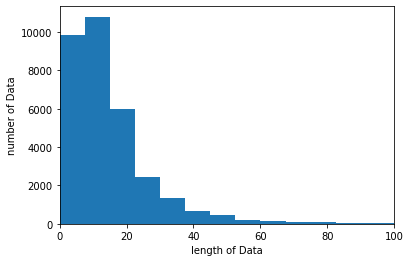

In [32]:
# x 길이 확인
print("train 최대 길이 : ", max(len(l) for l in X_train)) 
print("train 평균 길이 : ", sum(map(len, X_train))/ len(X_train)) 

plt.xlim([0, 100]) 
plt.hist([len(s) for s in X_train], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

### - y 원핫인코딩

In [33]:
# one- hot  encoding
import numpy as np 
y_train = [] 
y_test = [] 

for i in range(len(train_y)):
    if train_y.iloc[i] == 1: 
        y_train.append([0, 0, 1]) 
    elif train_y.iloc[i] == 0: 
        y_train.append([0, 1, 0]) 
    elif train_y.iloc[i] == -1: 
        y_train.append([1, 0, 0]) 

for i in range(len(test_y)): 
    if test_y[i] == 1: 
        y_test.append([0, 0, 1]) 
    elif test_y[i] == 0: 
        y_test.append([0, 1, 0]) 
    elif test_y[i] == -1: 
        y_test.append([1, 0, 0]) 
        
y_train = np.array(y_train) 
y_test = np.array(y_test)

test 최대 길이 :  78
test 평균 길이 :  12.15


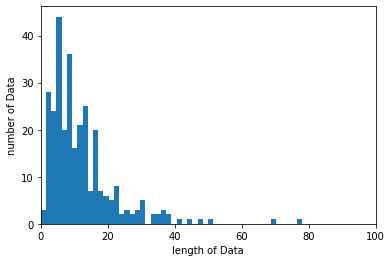

In [34]:
# y 길이확인
print("test 최대 길이 : ", max(len(l) for l in X_test)) 
print("test 평균 길이 : ", sum(map(len, X_test))/ len(X_test)) 

plt.xlim([0, 100]) 
plt.hist([len(s) for s in X_test], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

## 05. 모델 생성 / 학습 / 평가

In [35]:
from keras.layers import Embedding, Dense, LSTM, Conv1D 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences
max_len = 20 # 전체 데이터의 길이를 20로 맞춘다 
 
X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
model1 = Sequential() 
model1.add(Embedding(max_words, 100)) 
model1.add(LSTM(128)) 
model1.add(Dense(3, activation='softmax')) 

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])  #optimizer: rmsprop
history = model1.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.1)

Epoch 1/30
1256/1256 [==============================] - 21s 11ms/step - loss: 0.7670 - accuracy: 0.6620 - val_loss: 0.8473 - val_accuracy: 0.6337
Epoch 2/30
1256/1256 [==============================] - 13s 10ms/step - loss: 0.5587 - accuracy: 0.7729 - val_loss: 0.7958 - val_accuracy: 0.6602
Epoch 3/30
1256/1256 [==============================] - 13s 10ms/step - loss: 0.4813 - accuracy: 0.8068 - val_loss: 0.9345 - val_accuracy: 0.6265
Epoch 4/30
1256/1256 [==============================] - 13s 10ms/step - loss: 0.4194 - accuracy: 0.8348 - val_loss: 0.8786 - val_accuracy: 0.6961
Epoch 5/30
1256/1256 [==============================] - 13s 10ms/step - loss: 0.3621 - accuracy: 0.8604 - val_loss: 0.6698 - val_accuracy: 0.7333
Epoch 6/30
1256/1256 [==============================] - 12s 10ms/step - loss: 0.3095 - accuracy: 0.8827 - val_loss: 1.0135 - val_accuracy: 0.6595
Epoch 7/30
1256/1256 [==============================] - 13s 10ms/step - loss: 0.2579 - accuracy: 0.9048 - val_loss: 0.8832 -

In [ ]:
print('model1 전체정확도 : {:.2f}%'.format(model1.evaluate(X_test, y_test)[1]*100 ))

10/10 [==============================] - 0s 4ms/step - loss: 5.0769 - accuracy: 0.6300
model1 전체정확도 : 63.00%


In [ ]:
model2 = Sequential() 
model2.add(Embedding(max_words, 100)) 
model2.add(LSTM(128)) 
model2.add(Dense(3, activation='softmax')) 

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
history = model2.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.1)

Epoch 1/10
1256/1256 [==============================] - 19s 12ms/step - loss: 0.7198 - accuracy: 0.6885 - val_loss: 0.9693 - val_accuracy: 0.5663
Epoch 2/10
1256/1256 [==============================] - 14s 11ms/step - loss: 0.4388 - accuracy: 0.8303 - val_loss: 0.7576 - val_accuracy: 0.6953
Epoch 3/10
1256/1256 [==============================] - 14s 11ms/step - loss: 0.2923 - accuracy: 0.8910 - val_loss: 0.9288 - val_accuracy: 0.6774
Epoch 4/10
1256/1256 [==============================] - 14s 11ms/step - loss: 0.1922 - accuracy: 0.9301 - val_loss: 1.0430 - val_accuracy: 0.6789
Epoch 5/10
1256/1256 [==============================] - 14s 11ms/step - loss: 0.1308 - accuracy: 0.9532 - val_loss: 1.1091 - val_accuracy: 0.7018
Epoch 6/10
1256/1256 [==============================] - 14s 11ms/step - loss: 0.0870 - accuracy: 0.9690 - val_loss: 1.2430 - val_accuracy: 0.7075
Epoch 7/10
1256/1256 [==============================] - 14s 11ms/step - loss: 0.0615 - accuracy: 0.9792 - val_loss: 1.4073 -

In [ ]:
print('model2 전체 정확도 : {:.2f}%'.format(model2.evaluate(X_test, y_test)[1]*100 ))

10/10 [==============================] - 0s 4ms/step - loss: 2.3218 - accuracy: 0.5933
model2 전체 정확도 : 59.33%


In [36]:
# model3
import keras
model3 = Sequential() 
model3.add(Embedding(max_words, 100)) 
model3.add(Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]) )
model3.add(LSTM(128)) 
model3.add(Dense(3, activation='softmax')) 


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])  #optimizer: rmsprop
history3 = model3.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.1)


Epoch 1/30
2910/2910 [==============================] - 69s 12ms/step - loss: 0.6383 - accuracy: 0.7386 - val_loss: 0.4625 - val_accuracy: 0.8212
Epoch 2/30
2910/2910 [==============================] - 35s 12ms/step - loss: 0.4879 - accuracy: 0.8079 - val_loss: 0.4429 - val_accuracy: 0.8290
Epoch 3/30
2910/2910 [==============================] - 35s 12ms/step - loss: 0.4082 - accuracy: 0.8446 - val_loss: 0.4482 - val_accuracy: 0.8215
Epoch 4/30
2910/2910 [==============================] - 35s 12ms/step - loss: 0.3535 - accuracy: 0.8693 - val_loss: 0.4790 - val_accuracy: 0.8249
Epoch 5/30
2910/2910 [==============================] - 35s 12ms/step - loss: 0.3186 - accuracy: 0.8845 - val_loss: 0.4907 - val_accuracy: 0.8231
Epoch 6/30
2910/2910 [==============================] - 35s 12ms/step - loss: 0.2858 - accuracy: 0.8991 - val_loss: 0.5271 - val_accuracy: 0.8061
Epoch 7/30
2910/2910 [==============================] - 35s 12ms/step - loss: 0.2596 - accuracy: 0.9077 - val_loss: 0.5343 -

In [39]:
print('model3 전체 정확도 : {:.2f}%'.format(model3.evaluate(X_test, y_test)[1]*100 ))

10/10 [==============================] - 0s 7ms/step - loss: 4.1756 - accuracy: 0.6533
model3 전체 정확도 : 65.33%


In [ ]:
# model4
import keras
#import tensorflow as tf
lrelu= lambda x: keras.activations.relu(x, alpha=0.1)

max_words =1200
model4 = Sequential() 
model4.add(Embedding(max_words, 100)) 
model4.add(Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="causal",
                      activation=lrelu
                   #   input_shape=[None, 1]
                  ) )
model4.add(LSTM(128)) 
model4.add(Dense(3, activation='softmax')) 


#lr_schedule = keras.callbacks.LearningRateScheduler(
#    lambda epoch: 1e-8 * 10**(epoch / 20))

model4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])  #optimizer: rmsprop
history4 = model4.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.1)

Epoch 1/30
1256/1256 [==============================] - 19s 12ms/step - loss: 0.7689 - accuracy: 0.6632 - val_loss: 0.8250 - val_accuracy: 0.6530
Epoch 2/30
1256/1256 [==============================] - 14s 11ms/step - loss: 0.6208 - accuracy: 0.7450 - val_loss: 0.8200 - val_accuracy: 0.6559
Epoch 3/30
1256/1256 [==============================] - 14s 11ms/step - loss: 0.5617 - accuracy: 0.7668 - val_loss: 0.7436 - val_accuracy: 0.6688
Epoch 4/30
1256/1256 [==============================] - 14s 11ms/step - loss: 0.5146 - accuracy: 0.7912 - val_loss: 0.6752 - val_accuracy: 0.7190
Epoch 5/30
1256/1256 [==============================] - 14s 11ms/step - loss: 0.4658 - accuracy: 0.8100 - val_loss: 1.1424 - val_accuracy: 0.5627
Epoch 6/30
1256/1256 [==============================] - 14s 11ms/step - loss: 0.4182 - accuracy: 0.8358 - val_loss: 0.8665 - val_accuracy: 0.6452
Epoch 7/30
1256/1256 [==============================] - 14s 11ms/step - loss: 0.3653 - accuracy: 0.8560 - val_loss: 1.1696 -

In [ ]:
print('model4 전체 정확도 : {:.2f}%'.format(model4.evaluate(X_test, y_test)[1]*100 ))

10/10 [==============================] - 0s 6ms/step - loss: 4.1886 - accuracy: 0.6200
model4 전체 정확도 : 62.00%


In [37]:
# model5
import keras
# import tensorflow as tf
# lrelu= lambda x: keras.activations.relu(x, alpha=0.1)

max_words =1200
model5 = Sequential() 
model5.add(Embedding(max_words, 100)) 
model5.add(Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="causal",
                      activation= 'relu', #lrelu
                      input_shape=[None, 1] 
                  ) )
model5.add(LSTM(128)) 
model5.add(Dense(3, activation='softmax')) 

model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #optimizer: rmsprop
history5 = model5.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.1)

Epoch 1/30
2910/2910 [==============================] - 37s 11ms/step - loss: 0.6487 - accuracy: 0.7321 - val_loss: 0.4923 - val_accuracy: 0.8008
Epoch 2/30
2910/2910 [==============================] - 32s 11ms/step - loss: 0.5347 - accuracy: 0.7827 - val_loss: 0.4720 - val_accuracy: 0.8101
Epoch 3/30
2910/2910 [==============================] - 32s 11ms/step - loss: 0.4732 - accuracy: 0.8081 - val_loss: 0.4892 - val_accuracy: 0.8067
Epoch 4/30
2910/2910 [==============================] - 32s 11ms/step - loss: 0.4036 - accuracy: 0.8381 - val_loss: 0.5347 - val_accuracy: 0.8126
Epoch 5/30
2910/2910 [==============================] - 32s 11ms/step - loss: 0.3353 - accuracy: 0.8668 - val_loss: 0.5842 - val_accuracy: 0.7915
Epoch 6/30
2910/2910 [==============================] - 32s 11ms/step - loss: 0.2694 - accuracy: 0.8948 - val_loss: 0.6620 - val_accuracy: 0.7952
Epoch 7/30
2910/2910 [==============================] - 32s 11ms/step - loss: 0.2005 - accuracy: 0.9234 - val_loss: 0.7778 -

In [38]:
print('model5 전체 정확도 : {:.2f}%'.format(model5.evaluate(X_test, y_test)[1]*100 ))

10/10 [==============================] - 0s 7ms/step - loss: 3.0157 - accuracy: 0.6733
model5 전체 정확도 : 67.33%


In [40]:
# model5_2
import keras
# import tensorflow as tf
# lrelu= lambda x: keras.activations.relu(x, alpha=0.1)

max_words =1200
model5_2 = Sequential() 
model5_2.add(Embedding(max_words, 100)) 
model5_2.add(Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="causal",
                      activation= 'relu', #lrelu
                      input_shape=[None, 1] 
                  ) )
model5_2.add(LSTM(128)) 
model5_2.add(Dense(10, activation='relu'))
model5_2.add(Dense(10, activation='relu'))
model5_2.add(Dense(3, activation='softmax')) 

model5_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #optimizer: rmsprop
history5_2 = model5_2.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.1)

print('model5_2 전체 정확도 : {:.2f}%'.format(model5_2.evaluate(X_test, y_test)[1]*100 ))

Epoch 1/30
2910/2910 [==============================] - 38s 12ms/step - loss: 0.6839 - accuracy: 0.7182 - val_loss: 0.4903 - val_accuracy: 0.8048
Epoch 2/30
2910/2910 [==============================] - 33s 11ms/step - loss: 0.5492 - accuracy: 0.7789 - val_loss: 0.4831 - val_accuracy: 0.8045
Epoch 3/30
2910/2910 [==============================] - 33s 11ms/step - loss: 0.4911 - accuracy: 0.8021 - val_loss: 0.4880 - val_accuracy: 0.8135
Epoch 4/30
2910/2910 [==============================] - 33s 11ms/step - loss: 0.4361 - accuracy: 0.8250 - val_loss: 0.5154 - val_accuracy: 0.7980
Epoch 5/30
2910/2910 [==============================] - 33s 11ms/step - loss: 0.3831 - accuracy: 0.8468 - val_loss: 0.5219 - val_accuracy: 0.7980
Epoch 6/30
2910/2910 [==============================] - 33s 11ms/step - loss: 0.3266 - accuracy: 0.8723 - val_loss: 0.5819 - val_accuracy: 0.7906
Epoch 7/30
2910/2910 [==============================] - 33s 11ms/step - loss: 0.2734 - accuracy: 0.8937 - val_loss: 0.6154 -

In [41]:
# model5_3
import keras
# import tensorflow as tf
# lrelu= lambda x: keras.activations.relu(x, alpha=0.1)

max_words =1200
model5_3 = Sequential() 
model5_3.add(Embedding(max_words, 100)) 
model5_3.add(Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="causal",
                      activation= 'relu', #lrelu
                      input_shape=[None, 1] 
                  ) )
model5_3.add(LSTM(128)) 
model5_3.add(Dense(10, activation='relu'))
model5_3.add(Dense(10, activation='relu'))

model5_3.add(Dense(3, activation='softmax')) 

model5_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #optimizer: rmsprop
history5_3 = model5_3.fit(X_train, y_train, epochs=50, batch_size=20, validation_split=0.1)

print('model5_3 전체 정확도 : {:.2f}%'.format(model5_3.evaluate(X_test, y_test)[1]*100 ))

Epoch 1/50
1455/1455 [==============================] - 22s 13ms/step - loss: 0.7150 - accuracy: 0.7008 - val_loss: 0.4948 - val_accuracy: 0.8104
Epoch 2/50
1455/1455 [==============================] - 17s 12ms/step - loss: 0.5640 - accuracy: 0.7755 - val_loss: 0.4995 - val_accuracy: 0.8005
Epoch 3/50
1455/1455 [==============================] - 17s 12ms/step - loss: 0.5096 - accuracy: 0.7956 - val_loss: 0.4870 - val_accuracy: 0.8113
Epoch 4/50
1455/1455 [==============================] - 17s 12ms/step - loss: 0.4613 - accuracy: 0.8143 - val_loss: 0.4818 - val_accuracy: 0.8104
Epoch 5/50
1455/1455 [==============================] - 17s 12ms/step - loss: 0.4152 - accuracy: 0.8326 - val_loss: 0.5086 - val_accuracy: 0.8113
Epoch 6/50
1455/1455 [==============================] - 17s 12ms/step - loss: 0.3697 - accuracy: 0.8523 - val_loss: 0.5176 - val_accuracy: 0.7989
Epoch 7/50
1455/1455 [==============================] - 17s 12ms/step - loss: 0.3215 - accuracy: 0.8739 - val_loss: 0.5944 -

In [42]:
# model5_3
import keras
# import tensorflow as tf
# lrelu= lambda x: keras.activations.relu(x, alpha=0.1)

max_words =1200
model5_3 = Sequential() 
model5_3.add(Embedding(max_words, 100)) 
model5_3.add(Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="causal",
                      activation= 'relu', #lrelu
                      input_shape=[None, 1] 
                  ) )
model5_3.add(LSTM(128)) 
model5_3.add(Dense(10, activation='relu'))
model5_3.add(Dense(10, activation='relu'))

model5_3.add(Dense(3, activation='softmax')) 

model5_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #optimizer: rmsprop
history5_3 = model5_3.fit(X_train, y_train, epochs=50, batch_size=20, validation_split=0.1)

print('model5_3 전체 정확도 : {:.2f}%'.format(model5_3.evaluate(X_test, y_test)[1]*100 ))

Epoch 1/50
1455/1455 [==============================] - 21s 12ms/step - loss: 0.7189 - accuracy: 0.6958 - val_loss: 0.5135 - val_accuracy: 0.7940
Epoch 2/50
1455/1455 [==============================] - 17s 12ms/step - loss: 0.5600 - accuracy: 0.7773 - val_loss: 0.4828 - val_accuracy: 0.8101
Epoch 3/50
1455/1455 [==============================] - 17s 12ms/step - loss: 0.5044 - accuracy: 0.7958 - val_loss: 0.4739 - val_accuracy: 0.8045
Epoch 4/50
1455/1455 [==============================] - 17s 12ms/step - loss: 0.4527 - accuracy: 0.8192 - val_loss: 0.4834 - val_accuracy: 0.8076
Epoch 5/50
1455/1455 [==============================] - 17s 11ms/step - loss: 0.4004 - accuracy: 0.8396 - val_loss: 0.5219 - val_accuracy: 0.7993
Epoch 6/50
1455/1455 [==============================] - 17s 12ms/step - loss: 0.3503 - accuracy: 0.8617 - val_loss: 0.5544 - val_accuracy: 0.7968
Epoch 7/50
1455/1455 [==============================] - 17s 12ms/step - loss: 0.2922 - accuracy: 0.8885 - val_loss: 0.6330 -

In [43]:
# model6
import keras
# import tensorflow as tf
# lrelu= lambda x: keras.activations.relu(x, alpha=0.1)

max_words =1200
model6 = Sequential() 
model6.add(Embedding(max_words, 100)) 
model6.add(Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="causal",
                      activation= 'relu', #lrelu
                      input_shape=[None, 1] 
                  ) )
model6.add(LSTM(128)) 
model6.add(Dense(10, activation='relu')) 
model6.add(Dense(10, activation='relu')) 
model6.add(Dense(10, activation='relu')) 
model6.add(Dense(3, activation='softmax')) 


model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  #optimizer: rmsprop
history6 = model6.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.1)

Epoch 1/50
2910/2910 [==============================] - 36s 12ms/step - loss: 0.6846 - accuracy: 0.7150 - val_loss: 0.5306 - val_accuracy: 0.7853
Epoch 2/50
2910/2910 [==============================] - 33s 11ms/step - loss: 0.5541 - accuracy: 0.7771 - val_loss: 0.4875 - val_accuracy: 0.8054
Epoch 3/50
2910/2910 [==============================] - 33s 11ms/step - loss: 0.5010 - accuracy: 0.7986 - val_loss: 0.4875 - val_accuracy: 0.8082
Epoch 4/50
2910/2910 [==============================] - 33s 11ms/step - loss: 0.4517 - accuracy: 0.8171 - val_loss: 0.5056 - val_accuracy: 0.8036
Epoch 5/50
2910/2910 [==============================] - 33s 11ms/step - loss: 0.4045 - accuracy: 0.8361 - val_loss: 0.5269 - val_accuracy: 0.8095
Epoch 6/50
2910/2910 [==============================] - 34s 12ms/step - loss: 0.3556 - accuracy: 0.8557 - val_loss: 0.5574 - val_accuracy: 0.8033
Epoch 7/50
2910/2910 [==============================] - 34s 12ms/step - loss: 0.3055 - accuracy: 0.8774 - val_loss: 0.5966 -

In [44]:
print('model6 전체 정확도 : {:.2f}%'.format(model6.evaluate(X_test, y_test)[1]*100 ))

10/10 [==============================] - 0s 5ms/step - loss: 3.1076 - accuracy: 0.6633
model6 전체 정확도 : 66.33%


In [ ]:
# model1
print('model1 정확도 : {:.2f}%'.format(model1.evaluate(X_test[0:100], y_test[0:100])[1]*100 ))
print('model1 정확도 : {:.2f}%'.format(model1.evaluate(X_test[100:200], y_test[100:200])[1]*100 ))
print('model1 정확도 : {:.2f}%'.format(model1.evaluate(X_test[200:300], y_test[200:300])[1]*100 ))

mean_md1= ( model1.evaluate(X_test[0:100], y_test[0:100])[1]*100  +
           model1.evaluate(X_test[100:200], y_test[100:200])[1]*100 + 
           model1.evaluate(X_test[200:300], y_test[200:300])[1]*100  ) /3
print('model1의 정확도 평균 :',round(mean_md1,2),'%' )
print('---------------------------------------------------------------------------------------')
# model2
print('model2 정확도 : {:.2f}%'.format(model2.evaluate(X_test[0:100], y_test[0:100])[1]*100 ))
print('model2 정확도 : {:.2f}%'.format(model2.evaluate(X_test[100:200], y_test[100:200])[1]*100 ))
print('model2 정확도 : {:.2f}%'.format(model2.evaluate(X_test[200:300], y_test[200:300])[1]*100 ))

mean_md2= ( model2.evaluate(X_test[0:100], y_test[0:100])[1]*100  + 
           model2.evaluate(X_test[100:200], y_test[100:200])[1]*100 + 
           model2.evaluate(X_test[200:300], y_test[200:300])[1]*100  ) /3
print('model2의 정확도 평균 :',round(mean_md2,2),'%' )
print('---------------------------------------------------------------------------------------')
# model3
print('model3 정확도 : {:.2f}%'.format(model3.evaluate(X_test[0:100], y_test[0:100])[1]*100 ))
print('model3 정확도 : {:.2f}%'.format(model3.evaluate(X_test[100:200], y_test[100:200])[1]*100 ))
print('model3 정확도 : {:.2f}%'.format(model3.evaluate(X_test[200:300], y_test[200:300])[1]*100 ))

mean_md3= ( model3.evaluate(X_test[0:100], y_test[0:100])[1]*100  +
           model3.evaluate(X_test[100:200], y_test[100:200])[1]*100 +
           model3.evaluate(X_test[200:300], y_test[200:300])[1]*100  ) /3
print('model2의 정확도 평균 :',round(mean_md3,2),'%' )

print('---------------------------------------------------------------------------------------')
# model4
print('model4 정확도 : {:.2f}%'.format(model4.evaluate(X_test[0:100], y_test[0:100])[1]*100 ))
print('model4 정확도 : {:.2f}%'.format(model4.evaluate(X_test[100:200], y_test[100:200])[1]*100 ))
print('model4 정확도 : {:.2f}%'.format(model4.evaluate(X_test[200:300], y_test[200:300])[1]*100 ))

mean_md4= ( model4.evaluate(X_test[0:100], y_test[0:100])[1]*100  +
           model4.evaluate(X_test[100:200], y_test[100:200])[1]*100 +
           model4.evaluate(X_test[200:300], y_test[200:300])[1]*100  ) /3
print('model4의 정확도 평균 :',round(mean_md4,2),'%' )

4/4 [==============================] - 0s 6ms/step - loss: 3.2481 - accuracy: 0.6600
model1 정확도 : 66.00%
4/4 [==============================] - 0s 5ms/step - loss: 5.9072 - accuracy: 0.6100
model1 정확도 : 61.00%
4/4 [==============================] - 0s 5ms/step - loss: 6.0754 - accuracy: 0.6200
model1 정확도 : 62.00%
4/4 [==============================] - 0s 5ms/step - loss: 6.0754 - accuracy: 0.6200
model1의 정확도 평균 : 63.0 %
---------------------------------------------------------------------------------------
4/4 [==============================] - 0s 5ms/step - loss: 1.6995 - accuracy: 0.6700
model2 정확도 : 67.00%
4/4 [==============================] - 0s 5ms/step - loss: 2.3658 - accuracy: 0.5600
model2 정확도 : 56.00%
4/4 [==============================] - 0s 5ms/step - loss: 2.9001 - accuracy: 0.5500
model2 정확도 : 55.00%
4/4 [==============================] - 0s 5ms/step - loss: 2.9001 - accuracy: 0.5500
model2의 정확도 평균 : 59.33 %
---------------------------------------------------------------

In [45]:
print('---------------------------------------------------------------------------------------')
# model5
print('model5 정확도 : {:.2f}%'.format(model5.evaluate(X_test[0:100], y_test[0:100])[1]*100 ))
print('model5 정확도 : {:.2f}%'.format(model5.evaluate(X_test[100:200], y_test[100:200])[1]*100 ))
print('model5 정확도 : {:.2f}%'.format(model5.evaluate(X_test[200:300], y_test[200:300])[1]*100 ))

mean_md5 = ( model5.evaluate(X_test[0:100], y_test[0:100])[1]*100  +
            model5.evaluate(X_test[100:200], y_test[100:200])[1]*100 +
            model5.evaluate(X_test[200:300], y_test[200:300])[1]*100  ) /3
print('model5의 정확도 평균 :',round(mean_md5,2),'%' )

print('---------------------------------------------------------------------------------------')
# model5_2
print('model5_2 정확도 : {:.2f}%'.format(model5_2.evaluate(X_test[0:100], y_test[0:100])[1]*100 ))
print('model5_2 정확도 : {:.2f}%'.format(model5_2.evaluate(X_test[100:200], y_test[100:200])[1]*100 ))
print('model5_2 정확도 : {:.2f}%'.format(model5_2.evaluate(X_test[200:300], y_test[200:300])[1]*100 ))

mean_md5_2 = ( model5_2.evaluate(X_test[0:100], y_test[0:100])[1]*100  +
            model5_2.evaluate(X_test[100:200], y_test[100:200])[1]*100 +
            model5_2.evaluate(X_test[200:300], y_test[200:300])[1]*100  ) /3
print('model5_2의 정확도 평균 :',round(mean_md5_2,2),'%' )

print('---------------------------------------------------------------------------------------')
# model5_2
print('model5_3 정확도 : {:.2f}%'.format(model5_3.evaluate(X_test[0:100], y_test[0:100])[1]*100 ))
print('model5_3 정확도 : {:.2f}%'.format(model5_3.evaluate(X_test[100:200], y_test[100:200])[1]*100 ))
print('model5_3 정확도 : {:.2f}%'.format(model5_3.evaluate(X_test[200:300], y_test[200:300])[1]*100 ))

mean_md5_3 = ( model5_3.evaluate(X_test[0:100], y_test[0:100])[1]*100  +
            model5_3.evaluate(X_test[100:200], y_test[100:200])[1]*100 +
            model5_3.evaluate(X_test[200:300], y_test[200:300])[1]*100  ) /3
print('model5_3의 정확도 평균 :',round(mean_md5_3,2),'%' )


print('---------------------------------------------------------------------------------------')
# model6
print('model6 정확도 : {:.2f}%'.format(model6.evaluate(X_test[0:100], y_test[0:100])[1]*100 ))
print('model6 정확도 : {:.2f}%'.format(model6.evaluate(X_test[100:200], y_test[100:200])[1]*100 ))
print('model6 정확도 : {:.2f}%'.format(model6.evaluate(X_test[200:300], y_test[200:300])[1]*100 ))

mean_md6 = ( model6.evaluate(X_test[0:100], y_test[0:100])[1]*100  +
            model6.evaluate(X_test[100:200], y_test[100:200])[1]*100 +
            model6.evaluate(X_test[200:300], y_test[200:300])[1]*100  ) /3
print('model6의 정확도 평균 :',round(mean_md6,2),'%' )

---------------------------------------------------------------------------------------
4/4 [==============================] - 0s 11ms/step - loss: 2.8188 - accuracy: 0.6600
model5 정확도 : 66.00%
4/4 [==============================] - 0s 6ms/step - loss: 3.1963 - accuracy: 0.6900
model5 정확도 : 69.00%
4/4 [==============================] - 0s 7ms/step - loss: 3.0320 - accuracy: 0.6700
model5 정확도 : 67.00%
4/4 [==============================] - 0s 6ms/step - loss: 3.0320 - accuracy: 0.6700
model5의 정확도 평균 : 67.33 %
---------------------------------------------------------------------------------------
4/4 [==============================] - 0s 6ms/step - loss: 1.7159 - accuracy: 0.7900
model5_2 정확도 : 79.00%
4/4 [==============================] - 0s 9ms/step - loss: 2.5779 - accuracy: 0.6800
model5_2 정확도 : 68.00%
4/4 [==============================] - 0s 7ms/step - loss: 2.5037 - accuracy: 0.6900
model5_2 정확도 : 69.00%
4/4 [==============================] - 0s 7ms/step - loss: 2.5037 - accuracy:

## 06. pred set 예측 확인 (2015/ 2020 sns 감성분석진행3

In [46]:
#모델 확정 
model = model5_2

In [47]:
pred_df

,idx,sentence_Data,channel,year
0,0,한인마트는 귀찮아서 안가므로 떡볶이를 먹고싶을 때를 대비하여 이전에 마트에서 쌀가루...,blog,2015
1,1,그리고 오늘은 1월 1일 아무래도 설날이나 새해때 떡국을 안먹으면 억울하다 작년에도...,blog,2015
2,2,국물내는 재료따위 없는 나는 떡국까진 사치고 너무 먹고싶었던 고추가루엄청 많이 넣은...,blog,2015
3,3,블로그보면 쌀가루로 찹쌀떡진짜 잘 만들던데 내가만든건 만들다가 정말 빡쳤다는 것이 ...,blog,2015
4,4,라는 생각으로 만듬 찹쌀떡이없는 나라에서 산다해도 안먹고 말거야,blog,2015
...,...,...,...,...
116516,33289,식용유 미림맛술 꿀 이렇게 3가지 양념만 넣고 조리 했는데 맛이 와 비린맛 잘 잡아...,cafe,2015
116517,33290,가능한가요 믹서기 청소가 귀찮아서,cafe,2015
116518,33291,담주부터 초기이유식 시작인데 아직 애가 못앉잖아요 다들 그냥 분유주듯 안아서 먹이시나요,cafe,2015
116519,33292,어뭉들어디서 사드시나요 아이간식사먹이는 사이트추천좀해주셔요,cafe,2015


In [56]:
# data_content

# pred 토큰화 벡터화
X_pred = [] 
for sentence in pred_df['sentence_Data'] :
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_pred.append(temp_X) 

#벡터, 토큰화   
# 정수 인코딩
tokenizer.fit_on_texts(X_pred ) 
X_pred  = tokenizer.texts_to_sequences(X_pred ) 

# 데이터 길이 맞추기 : padding  씌움
X_pred = pad_sequences(X_pred, maxlen=max_len)

##model으로 해보기
# pred로 감성분석 예측
predict = model.predict( X_pred )
predict_labels = np.argmax(predict, axis=1) 

## 데이터 확인 
st, pred,channel,year =[],[],[],[]
# 데이터 직접 비교해보기
for i in range( len(pred_df) ): 
    st.append( pred_df['sentence_Data'].iloc[i] ) ,
    channel.append( pred_df['channel'].iloc[i] ),
    year.append( pred_df['year'].iloc[i] ),
    pred.append( predict_labels[i])

# 2가 긍정 / 1이 중립 / 0이 부정임을 확인
#0,1,2로 이루어진 pred -1, 0 ,1 로바꾸기
pnr=[]
for i in range(len(pred)):
    if pred[i] == 0:
        pnr.append(-1)
    elif pred[i] ==1:
        pnr.append(0)
    else:
        pnr.append(1)
    
# 데이터프레임 만들기
total_ex = pd.DataFrame({'문장' : st , '감성':pnr ,'분류:': pred ,'channel':channel,'year':year} )
total_ex


,문장,감성,분류:,channel,year
0,초기이유식 2단계 소고기미음 차례 나는 튼이이유식 책을보고 만들고 있는데 초기는 책...,0,1,blog,2020
1,중기이유식 들어가면서 큐브만들고 책 보는중 무튼 엄마들이라면 이유식만들때 참고하는 ...,-1,0,blog,2020
2,나도 도서관에서 2개의 이유식책을 빌렸는데 쌀미음 다음에 순서가 달랐다,1,2,blog,2020
3,하나는 야채 하나는 철분을 위해 소고기 나는 완분임에도 야채부터 하고 소고기를 들어...,1,2,blog,2020
4,최대한 지방없는걸로 달라고 했는데 잘 모르겠다,0,1,blog,2020
...,...,...,...,...,...
148895,재난카드 정부재난카드 카드 온누리 평택사랑권 다가능해요,1,2,cafe,2020
148896,주문방법 참고하셔서 주문 주세요,0,1,cafe,2020
148897,2만원 이상 무료배달해드려요 2만원 미만은 배송료 2천원입니다 주 문 방 법 1 문...,0,1,cafe,2020
148898,2 문자로 동 호수 연락처 보내주시면 주문완료 3 계좌입금 해주시는 분들은 꼭 동 ...,1,2,cafe,2020


In [57]:
#엑셀로 저장
total_ex.to_excel(f'pred2_cnnlstm_2020.xlsx',encoding='utf-8')